Auto Insurance Crash Risk Modeling
Full Jupyter Notebook Pipeline
SC, PA, TN + FARS National Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, mean_squared_error, r2_score, precision_score, 
                             recall_score, f1_score, accuracy_score)
from imblearn.over_sampling import SMOTE

In [2]:
# 📍 CONFIGURATION
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/"
save_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7"

sc_file = "sc_cleaned_combined_2013_2022.csv"
tn_file = "TN_PROCESSED_corrected_v2.csv"
pa_file = "PA_PROCESSED_corrected.csv"
fars_file = "FARS_combined_2013_2023_v5.csv"

test_mode = True
sample_frac = 0.01 if test_mode else 1.0

crash_cost_mapping = {0: 2000, 1: 1200000, 2: 167000, 3: 44000, 4: 27000, 8: 20000, 9: 20000}

# ✅ Load Data
def load_dataset(filepath):
    df = pd.read_csv(filepath, dtype=str)
    df = df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    df["crash_date"] = pd.to_datetime(df["crash_date"], errors='coerce')
    df["severity_level"] = pd.to_numeric(df["severity_level"], errors='coerce')
    df["driver_age"] = pd.to_numeric(df["driver_age"], errors='coerce')
    df["opioid_flag"] = pd.to_numeric(df["opioid_flag"], errors='coerce')
    df["alcohol_flag"] = pd.to_numeric(df["alcohol_flag"], errors='coerce')
    df["any_drug_flag"] = pd.to_numeric(df["any_drug_flag"], errors='coerce')
    return df

sc_df = load_dataset(os.path.join(base_path, sc_file))
tn_df = load_dataset(os.path.join(base_path, tn_file))
pa_df = load_dataset(os.path.join(base_path, pa_file))
fars_df = load_dataset(os.path.join(base_path, fars_file))

merged_df = pd.concat([sc_df, tn_df, pa_df], ignore_index=True)
merged_df['dataset_tag'] = 'SC+PA+TN'
fars_df['dataset_tag'] = 'FARS'

print(f"Merged dataset shape: {merged_df.shape}")
print(f"FARS dataset shape: {fars_df.shape}")

Merged dataset shape: (175672, 16)
FARS dataset shape: (10561, 20)


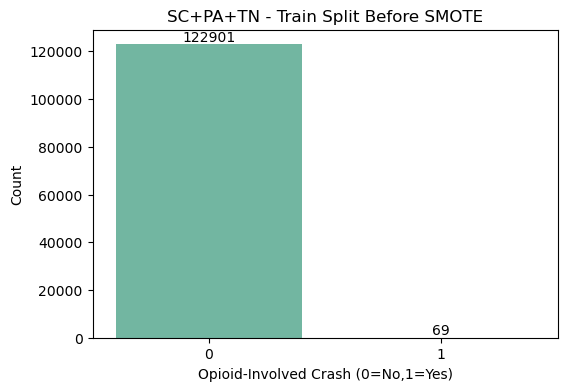

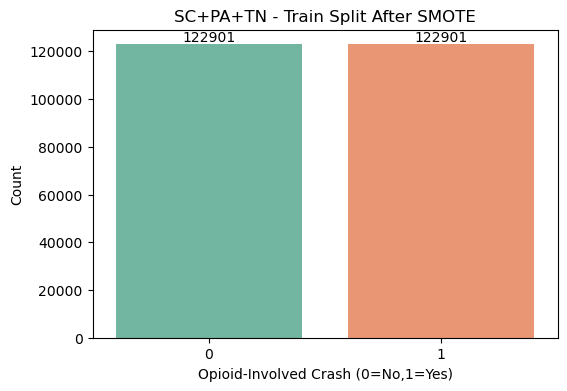

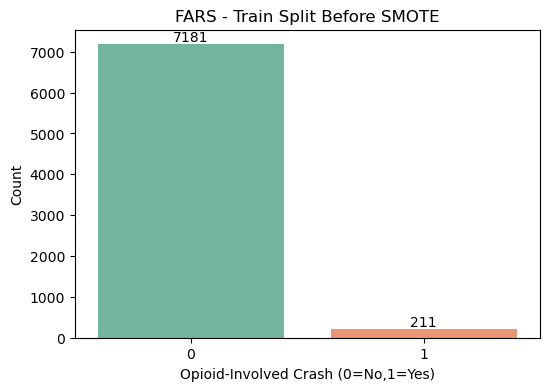

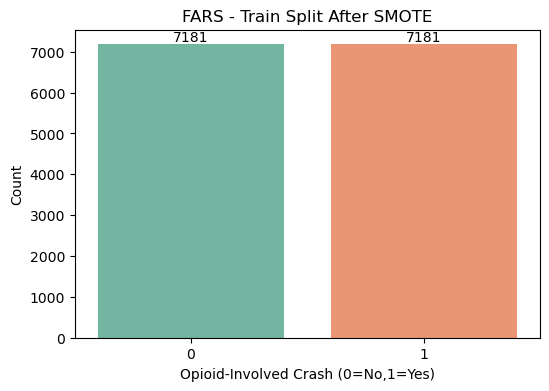

In [3]:
# 🚦 Split function with stratified split + visualize class imbalance
def split_and_balance(df, target, dataset_name):
    X = df[['driver_age', 'alcohol_flag', 'any_drug_flag']].fillna(0)
    y = df[target]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    def plot_distribution(y_data, title, file_tag):
        counts = y_data.value_counts()
        plt.figure(figsize=(6,4))
        sns.barplot(x=counts.index, y=counts.values, palette='Set2')
        for i, val in enumerate(counts.values):
            plt.text(i, val + 0.01 * max(counts.values), f'{val}', ha='center')
        plt.title(f"{dataset_name} - {title}")
        plt.xlabel("Opioid-Involved Crash (0=No,1=Yes)")
        plt.ylabel("Count")
        plt.savefig(f"{save_path}/{dataset_name}_{file_tag}.png")
        plt.show()

    plot_distribution(y_train, "Train Split Before SMOTE", "train_before_smote")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    plot_distribution(pd.Series(y_train_smote), "Train Split After SMOTE", "train_after_smote")

    return X_train_smote, X_val, X_test, y_train_smote, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_and_balance(merged_df, 'opioid_flag', 'SC+PA+TN')
X_train_f, X_val_f, X_test_f, y_train_f, y_val_f, y_test_f = split_and_balance(fars_df, 'opioid_flag', 'FARS')

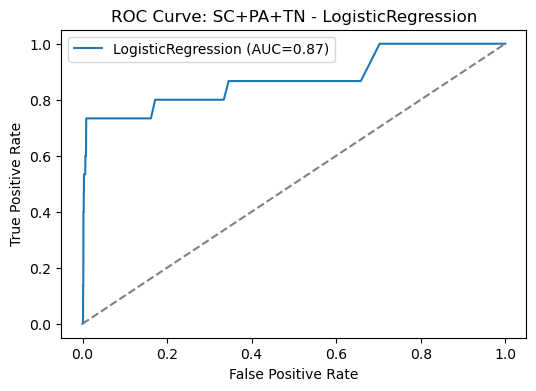

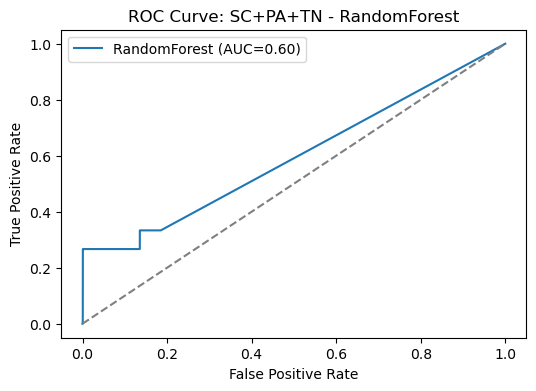

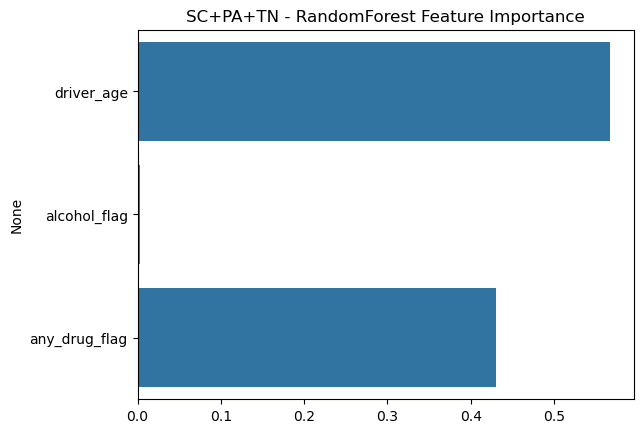

100%|===================| 52590/52702 [05:39<00:00]        

<Figure size 640x480 with 0 Axes>

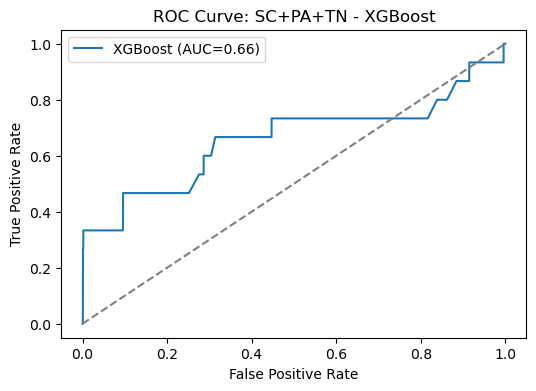

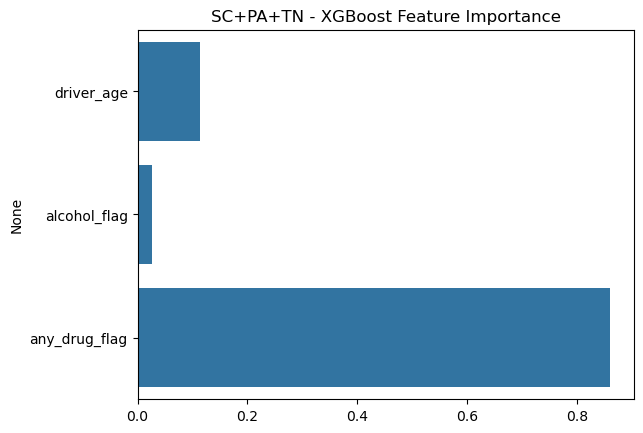

100%|===================| 26294/26351 [01:02<00:00]        

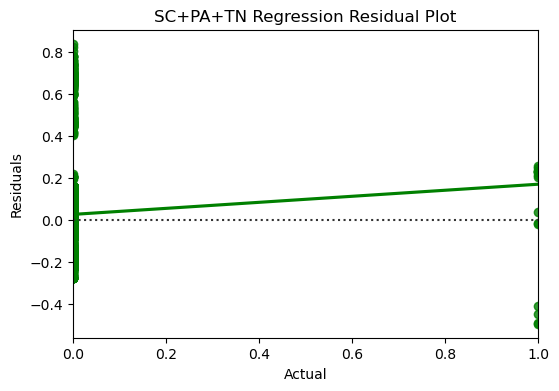

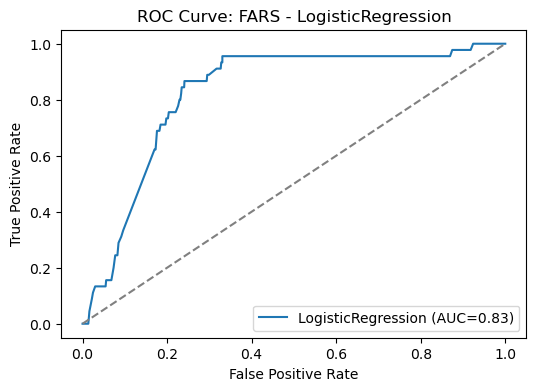

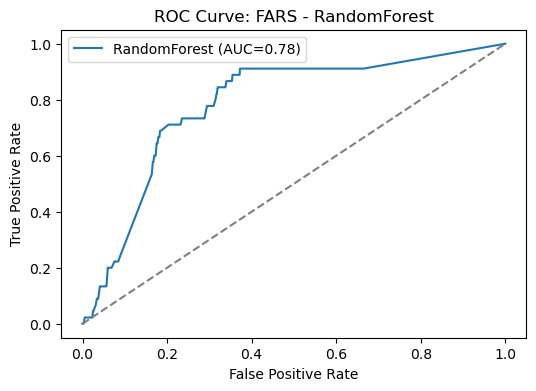

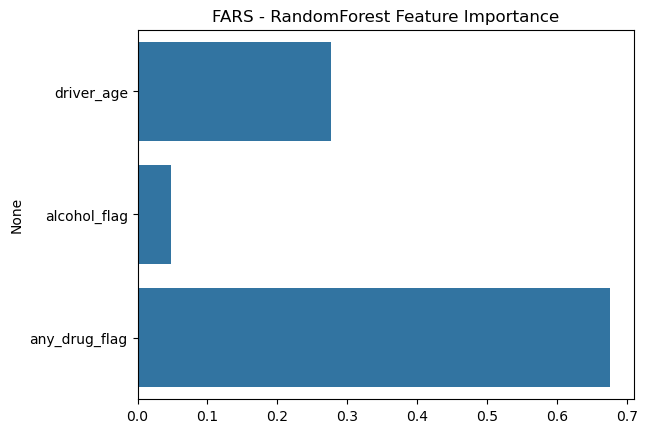

 98%|===================| 3112/3168 [00:26<00:00]        

<Figure size 640x480 with 0 Axes>

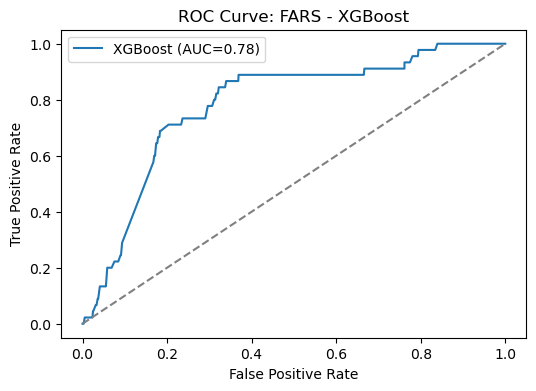

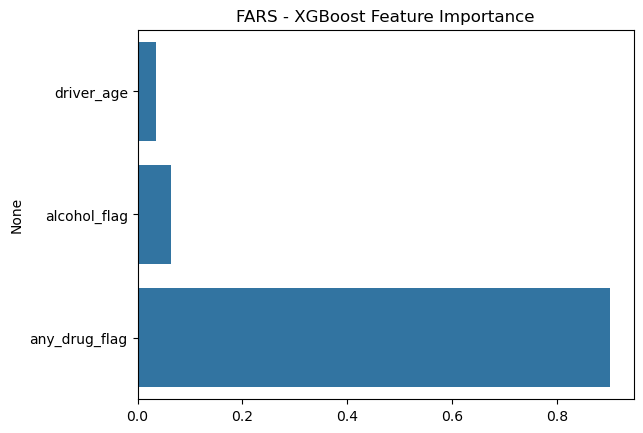

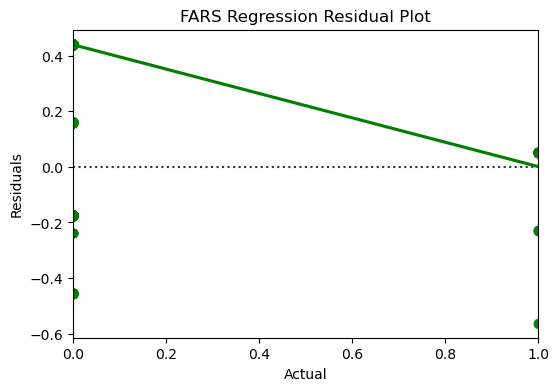

In [4]:
# ✅ Model training + evaluation function
def train_and_evaluate(X_train, X_val, y_train, y_val, dataset_name):
    results = {}
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=100),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1]

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)

        results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc}

        report = classification_report(y_val, y_pred, output_dict=True)
        pd.DataFrame(report).transpose().to_csv(f"{save_path}/{dataset_name}_{name}_classification_report.csv")
        cm = confusion_matrix(y_val, y_pred)
        pd.DataFrame(cm).to_csv(f"{save_path}/{dataset_name}_{name}_confusion_matrix.csv")

        # ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
        plt.plot([0,1], [0,1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {dataset_name} - {name}")
        plt.legend()
        plt.savefig(f"{save_path}/{dataset_name}_{name}_ROC.png")
        plt.show()

        # Feature importance (skip logistic regression coefficients)
        if name != "LogisticRegression":
            importances = model.feature_importances_
            sns.barplot(x=importances, y=X_train.columns)
            plt.title(f"{dataset_name} - {name} Feature Importance")
            plt.savefig(f"{save_path}/{dataset_name}_{name}_FeatureImportance.png")
            plt.show()

        # SHAP explainability
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_val)
        shap.summary_plot(shap_values, X_val, show=False)
        plt.savefig(f"{save_path}/{dataset_name}_{name}_SHAP.png")
        plt.close()

    # Regression model
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred_reg = reg.predict(X_val)
    r2 = r2_score(y_val, y_pred_reg)
    rmse = mean_squared_error(y_val, y_pred_reg, squared=False)
    mae = np.mean(np.abs(y_val - y_pred_reg))
    mape = np.mean(np.abs((y_val - y_pred_reg) / np.clip(y_val, 1e-5, None)))
    results['Regression'] = {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    # Residual plot
    plt.figure(figsize=(6,4))
    sns.residplot(x=y_val, y=y_pred_reg, lowess=True, color='g')
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title(f"{dataset_name} Regression Residual Plot")
    plt.savefig(f"{save_path}/{dataset_name}_Regression_Residuals.png")
    plt.show()

    return pd.DataFrame(results).T

results_scpatn = train_and_evaluate(X_train, X_val, y_train, y_val, 'SC+PA+TN')
results_fars = train_and_evaluate(X_train_f, X_val_f, y_train_f, y_val_f, 'FARS')

In [5]:
# ✅ Leaderboard + Export
leaderboard = pd.concat([results_scpatn, results_fars], keys=['SC+PA+TN', 'FARS'])
leaderboard.to_csv(f"{save_path}/model_leaderboard.csv")
print(leaderboard)

# ✅ Markdown commentary (insert as Markdown cells in your notebook)
"""
## Model Leaderboard Summary

- We compared Logistic Regression, Random Forest, XGBoost, and Linear Regression across SC+PA+TN and FARS datasets.
- Metrics reported include Accuracy, Precision, Recall, F1, AUC, R², RMSE, MAE, and MAPE.
- Feature importance and SHAP plots reveal the relative impact of driver age, alcohol, and drug flags.
- Residual plots and confusion matrices are saved for detailed error analysis.

## Next Steps

- Optimize hyperparameters via grid search.
- Explore additional features (e.g., weather, time of day).
- Apply cost-sensitive learning due to severe class imbalance.
- Communicate key findings to the business team with exported CSV and visual summaries.
"""

                             Accuracy  Precision    Recall        F1  \
SC+PA+TN LogisticRegression  0.981746   0.022541  0.733333  0.043738   
         RandomForest        0.905658   0.001614  0.266667  0.003208   
         XGBoost             0.904178   0.001984  0.333333  0.003945   
         Regression               NaN        NaN       NaN       NaN   
FARS     LogisticRegression  0.738636   0.087248  0.866667  0.158537   
         RandomForest        0.713384   0.069474  0.733333  0.126923   
         XGBoost             0.714015   0.069620  0.733333  0.127168   
         Regression               NaN        NaN       NaN       NaN   

                                  AUC          R2      RMSE       MAE  \
SC+PA+TN LogisticRegression  0.872852         NaN       NaN       NaN   
         RandomForest        0.595784         NaN       NaN       NaN   
         XGBoost             0.659012         NaN       NaN       NaN   
         Regression               NaN -167.320103  0.309451

'\n## Model Leaderboard Summary\n\n- We compared Logistic Regression, Random Forest, XGBoost, and Linear Regression across SC+PA+TN and FARS datasets.\n- Metrics reported include Accuracy, Precision, Recall, F1, AUC, R², RMSE, MAE, and MAPE.\n- Feature importance and SHAP plots reveal the relative impact of driver age, alcohol, and drug flags.\n- Residual plots and confusion matrices are saved for detailed error analysis.\n\n## Next Steps\n\n- Optimize hyperparameters via grid search.\n- Explore additional features (e.g., weather, time of day).\n- Apply cost-sensitive learning due to severe class imbalance.\n- Communicate key findings to the business team with exported CSV and visual summaries.\n'